In [1]:
#各ライブラリのimport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<p>
<h4>交差検証</h4>
　交差検証とはデータの解析と評価を交差させることで、より正確な推定値を求める手法。
<br>
　ハイパーパラメータの調整には検証データを用いる。そのため、1つの検証データだけでは、最適な値か判断できない場合がある。そのため、交差検証を用いて一番評価の良いハイパーパラメータに調整する。
<h4>K-Fold</h4>
　K分割交差検証（以下K-Fold）は最も一般的な交差検証である。データをK個に分割し、K-1個を訓練データ、1個をテストデータとし、データを交差させながらK回行い、得られた結果の平均値を求める。
<br>
　交差検証は、split()メソッドをfor文で扱うことで実装できる。
</p>

In [2]:
#検証曲線実装
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成in_test['displacement']
#df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正
#国とメーカーカラムの結合
df_train_test['manufacturers_country'] = df_train_test['manufacturers name'] + df_train_test['origin'].astype(str)
#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['manufacturers_country'] , dtype = int)
df_train = df_number.iloc[:199 , :]
df_test = df_number.iloc[199: , :]

#学習
#目的変数の分離
X = df_train.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','manufacturers name','weight'] , axis = 1)
y = df_train['mpg']
features_test = df_test.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','manufacturers name','weight'] , axis = 1)
#交差検証の評価指標をRSMEに指定
scoring = 'neg_mean_squared_error'
#import
import xgboost as xgb
from xgboost import XGBRegressor
# モデル作成
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=42, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
#K-分割交差検証
#交差検証は比較的少ないデータセットを使って学習する場合に、過学習を防ぐ（汎化性能を上げる）ためにする
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)

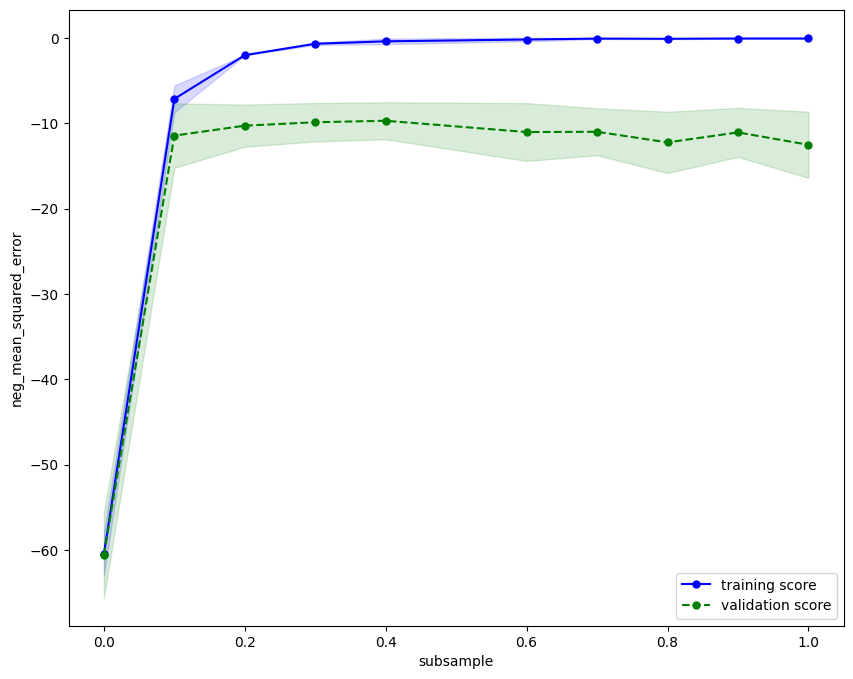

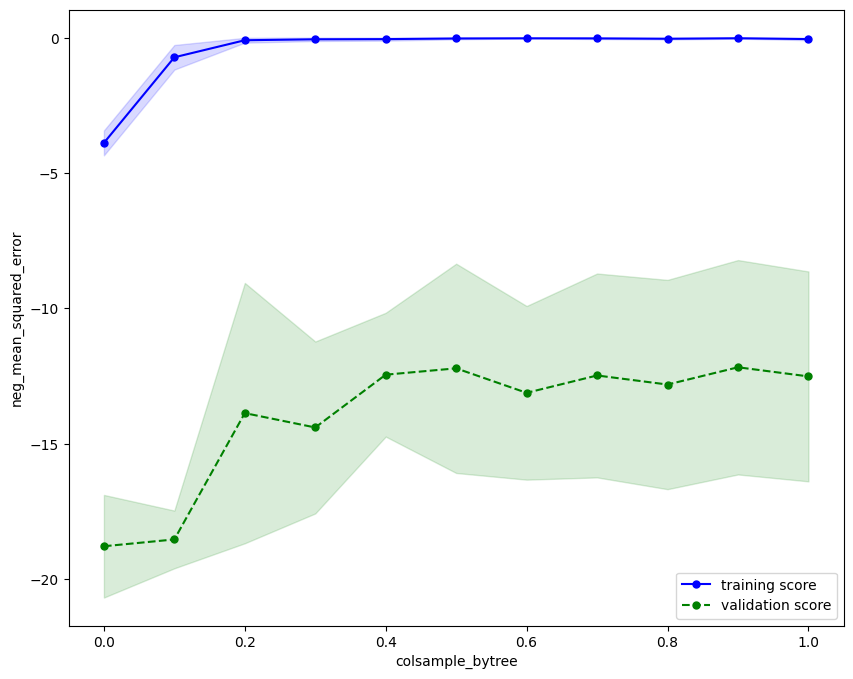

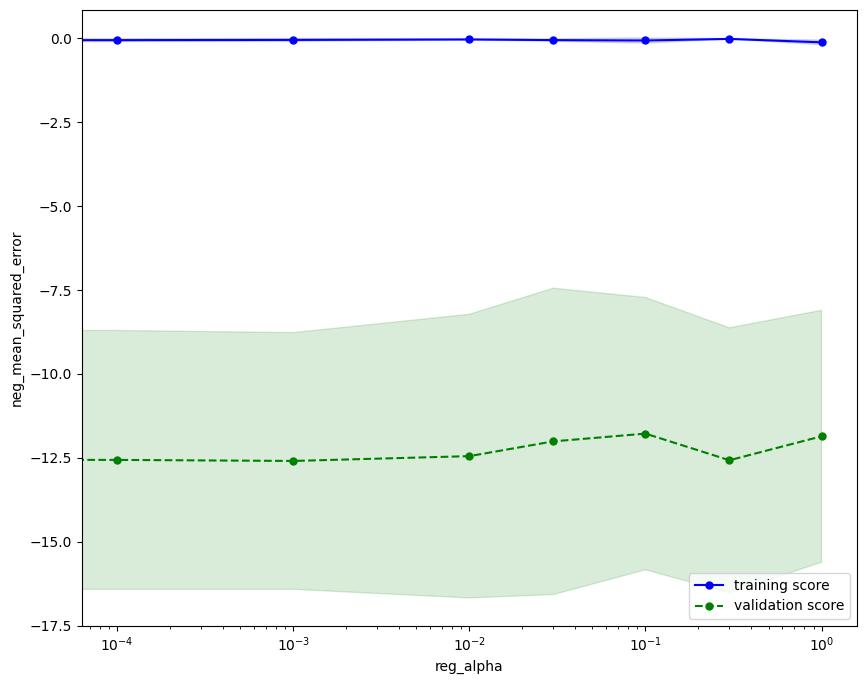

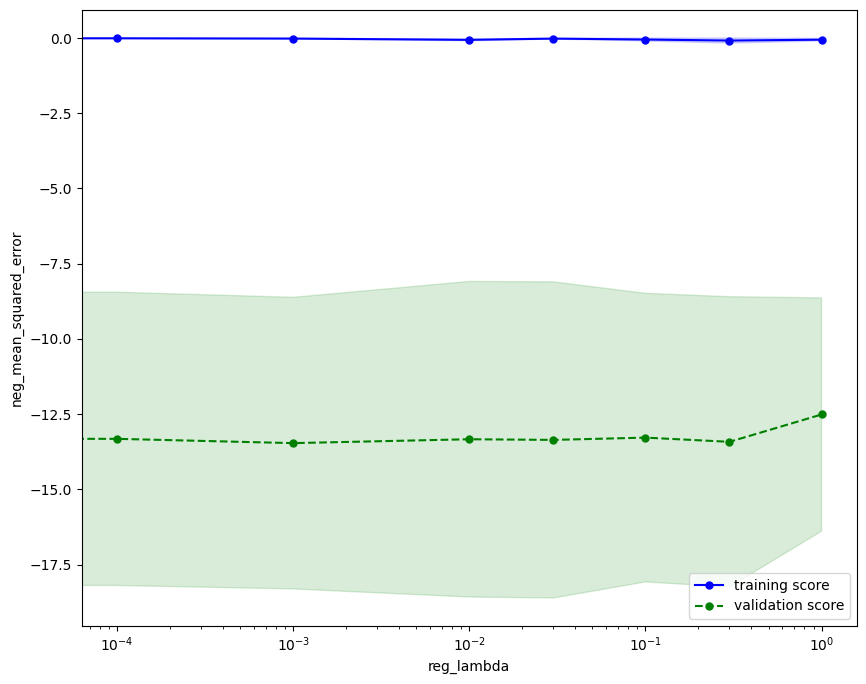

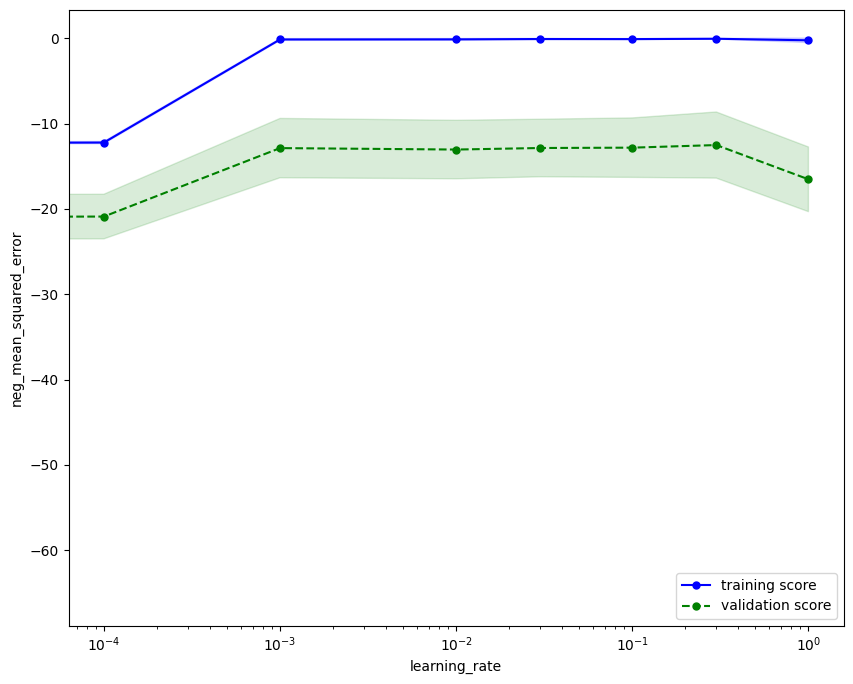

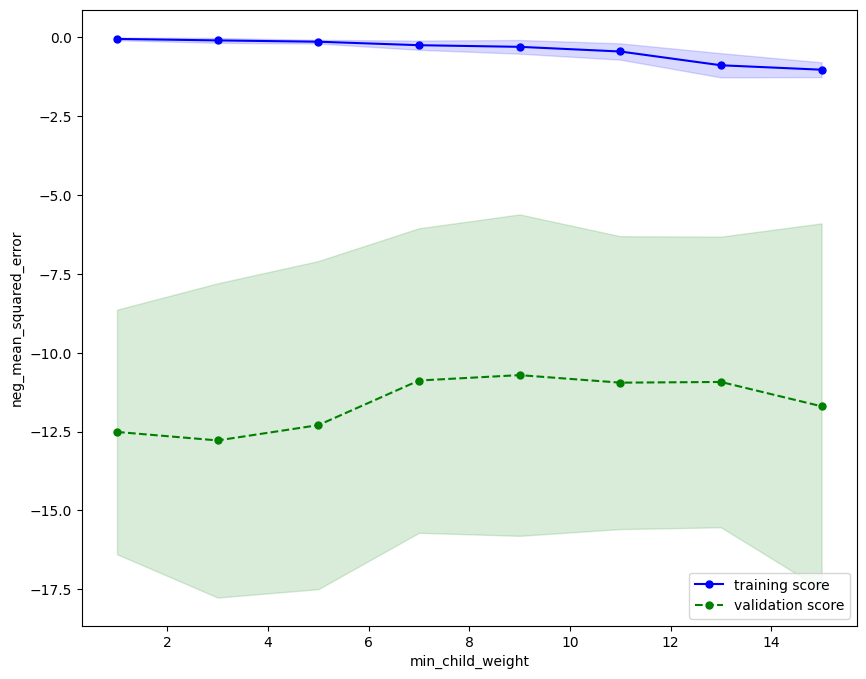

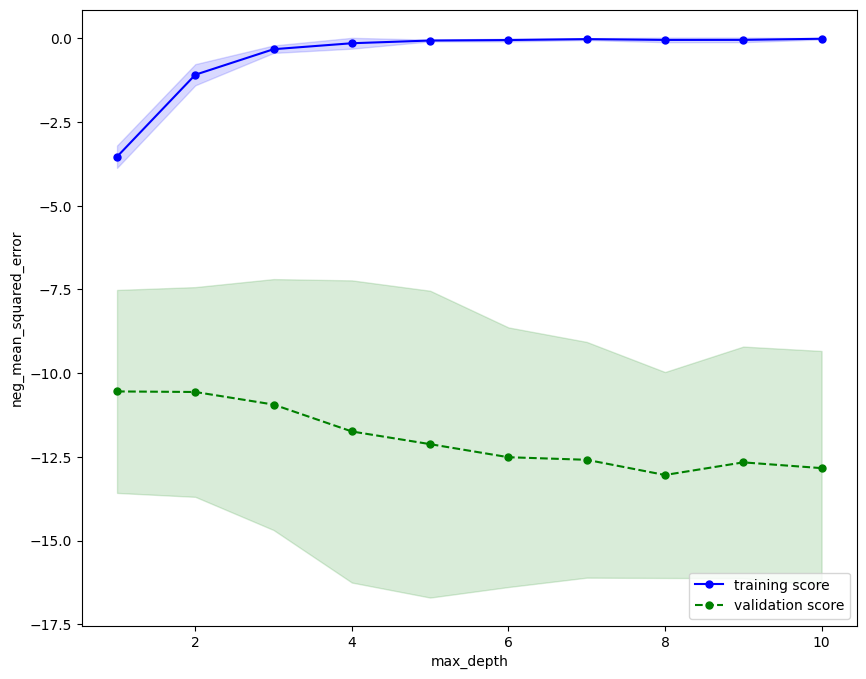

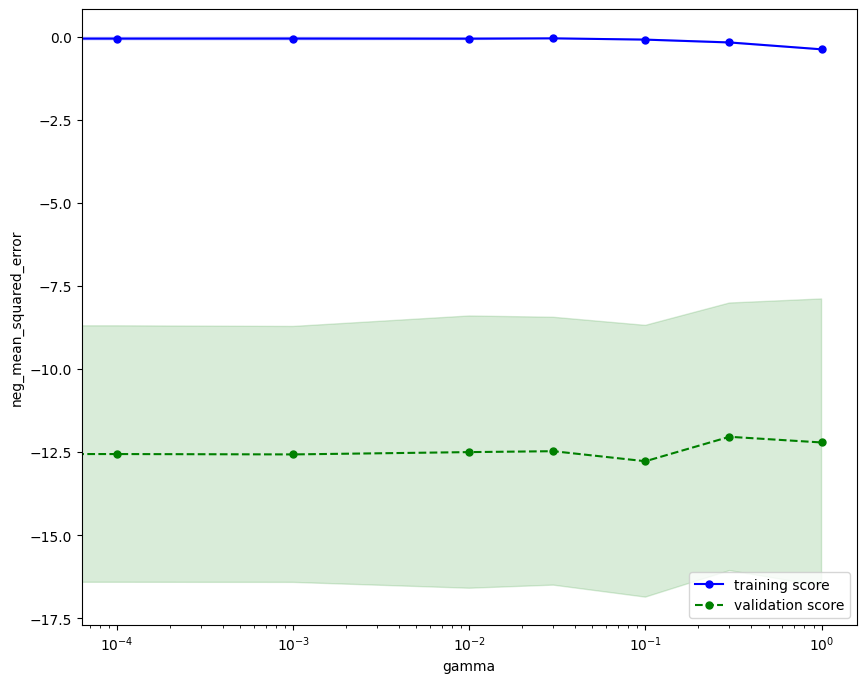

In [12]:
#検証曲線
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
#辞書オブジェクト = {'key' : 要素}
#オブジェクト.items(): 各要素のキーと値に対してforループ処理
cv_params = {'subsample': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'reg_lambda': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'learning_rate': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'gamma': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0]
             }
param_scales = {'subsample': 'linear',
                'colsample_bytree': 'linear',
                'reg_alpha': 'log',
                'reg_lambda': 'log',
                'learning_rate': 'log',
                'min_child_weight': 'linear',
                'max_depth': 'linear',
                'gamma': 'log'
                }
#for文の基本構造
#for 変数名(任意) in イテラブルオブジェクト:
    #処理

#enumerate()；forループでindexを取得する関数,デフォルトだと0から
#複数のイテラブルオブジェクト（リストなど）の要素を複数の変数として取得するにはzip()を使う
#names = ['Alice', 'Bob', 'Charlie']
#ages = [24, 50, 18]
#for name, age in zip(names, ages):
    #print(name, age)
# Alice 24
# Bob 50
# Charlie 18

#複数のイテラブルオブジェクト（リストなど）の要素とインデックス（カウンタ）を同時に取得するにはenumerate()とzip()を組み合わせて使う。
#(k,v)はインデックスをつける任意のオブジェクト
#k,vという変数にcv_paramsのkeyと要素の値をそれぞれ格納していくイメージ
#

for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X, y=y,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)#n_jobs: 同時実行数(-1: コア数で並列実行)
   # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.rcParams["figure.figsize"] = [10 , 8]#グラフのサイズ指定(これより下のグラフすべてに適用される、グローバルなイメージ)
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例

    # グラフを描画
    plt.show()    


In [28]:
#optunaによるベイズ最適化
import optuna
from sklearn.model_selection import cross_val_score
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 8),
        'max_depth': trial.suggest_int('max_depth', 1, 4),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 0.1, log=True),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.1, log=True),
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(bayes_objective, n_trials=100)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
model.set_params(**best_params)
df_pred = pd.DataFrame(model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)

[I 2024-03-06 23:07:38,327] A new study created in memory with name: no-name-53dfbf72-31d7-46c6-8398-61d239daf7b9
[I 2024-03-06 23:07:42,255] Trial 0 finished with value: -8.53856597905776 and parameters: {'learning_rate': 0.03574712922600244, 'min_child_weight': 8, 'max_depth': 3, 'colsample_bytree': 0.6789267873576292, 'subsample': 0.3248149123539492, 'reg_alpha': 0.002051110418843397, 'reg_lambda': 0.0013066739238053278, 'gamma': 0.0396760507705299}. Best is trial 0 with value: -8.53856597905776.
[I 2024-03-06 23:07:44,796] Trial 1 finished with value: -9.768371484882726 and parameters: {'learning_rate': 0.07725378389307355, 'min_child_weight': 6, 'max_depth': 1, 'colsample_bytree': 0.9759278817295955, 'subsample': 0.8659541126403374, 'reg_alpha': 0.0026587543983272706, 'reg_lambda': 0.0023102018878452934, 'gamma': 0.0003549878832196505}. Best is trial 0 with value: -8.53856597905776.
[I 2024-03-06 23:07:47,273] Trial 2 finished with value: -8.926167673465349 and parameters: {'learn

NotFittedError: need to call fit or load_model beforehand

In [29]:
best_params

{'learning_rate': 0.09297297094382827,
 'min_child_weight': 4,
 'max_depth': 2,
 'colsample_bytree': 0.6968612950209002,
 'subsample': 0.49194711916512684,
 'reg_alpha': 0.0019008940806647537,
 'reg_lambda': 0.026212898565639447,
 'gamma': 0.00022136464537129692}

In [30]:
# 最終的なパラメータ範囲(変数除去)
#検証曲線から考えられる適切なパラメータの範囲
#過学習(検証データと学習データのスコアが離れてる傾向)、未学習(両データのスコアが下降している)の範囲は避ける
#reg_alpha :[ 0.01,0.03,0.1,0.2,1]
#colsample_bytree ; 0.3 , 0.4,0.5,0.6
#gamma ; 0,01,0.03,0.1,0.3,1
#reg_lamba;0.1,0.3,1
#'max_depth': [2, 3, 4]

cv_params = {'learning_rate': [0.001, 0.01, 0.1, 0.2],#学習率(0～1)
             'min_child_weight': [5, 7, 9, 11],#決定木の葉の重みの下限
             'max_depth': [2 ,3 ,4],
             'colsample_bytree': [0.2, 0.4, 0.6, 0.9],#説明変数のサンプル抽出比(木)(0~1)
             'subsample': [0.1, 0.3, 0.4, 0.6],#各決定木のサンプル抽出比(0~1)、小さいほど保守的になる
             'reg_alpha' :[ 0.01,0.1,0.2,1]
             }
# グリッドサーチのインスタンス作成
#引数一覧
#estimator: チューニングを行うモデル
#param_grid: パラメータ候補パラメータ名: [候補リスト]
#scoring: 評価指標(今回はneg_mean_squared_error(RSME))
#cv: Cross Validationの分割数(default: 3)
#verbose: ログ出力レベル
#n_jobs: 同時実行数(-1: コア数で並列実行)
#refit: 　trueのとき最良のパラメータで再学習
from sklearn.model_selection import GridSearchCV
grid_model = GridSearchCV(model, cv_params,cv = cv,
                      scoring='neg_mean_squared_error', n_jobs=-1)
grid_model.fit(X , y , **fit_params )
best = grid_model.best_estimator_

df_pred = pd.DataFrame(best.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)

In [2]:
#モデル実装(train,test結合版)early stopping round実装
#gridsearch版

#kfoldを入れ、pwrカラムを追加しない時が一番高かった。
#欠損値補完と標準化の間にエンコーディングの操作を入れるとエラーが出てしまったため改善しよう
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成in_test['displacement']
#df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正
#国とメーカーカラムの結合
df_train_test['manufacturers_country'] = df_train_test['manufacturers name'] + df_train_test['origin'].astype(str)
#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['manufacturers_country'] , dtype = int)
df_train = df_number.iloc[:199 , :]
df_test = df_number.iloc[199: , :]

#学習
#目的変数の分離
X = df_train.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','manufacturers name','weight'] , axis = 1)
y = df_train['mpg']
features_test = df_test.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','manufacturers name','weight'] , axis = 1)
#import
import xgboost as xgb
from xgboost import XGBRegressor
# モデル作成
model = XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=42, n_estimators=10000)  # チューニング前のモデル
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
#K-分割交差検証
#交差検証は比較的少ないデータセットを使って学習する場合に、過学習を防ぐ（汎化性能を上げる）ためにする
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)
#gridsearch
from sklearn.model_selection import GridSearchCV

# 最終的なパラメータ範囲
cv_params = {'learning_rate': [0.01, 0.03, 0.1, 0.3],#学習率(0～1)
             'min_child_weight': [2, 4, 6, 8],#決定木の葉の重みの下限
             'max_depth': [1, 2, 3, 4],#決定木の最大深度(整数)
             'colsample_bytree': [0.2, 0.5, 0.8, 1.0],#説明変数のサンプル抽出比(木)(0~1)
             'subsample': [0.2, 0.5, 0.8, 1.0]#各決定木のサンプル抽出比(0~1)、小さいほど保守的になる
             }
# グリッドサーチのインスタンス作成
#引数一覧
#estimator: チューニングを行うモデル
#param_grid: パラメータ候補パラメータ名: [候補リスト]
#scoring: 評価指標(今回はneg_mean_squared_error(RSME))
#cv: Cross Validationの分割数(default: 3)
#verbose: ログ出力レベル
#n_jobs: 同時実行数(-1: コア数で並列実行)
#refit: 　trueのとき最良のパラメータで再学習

grid_model = GridSearchCV(model, cv_params,cv = cv,
                      scoring='neg_mean_squared_error', n_jobs=-1)
grid_model.fit(X , y , **fit_params )
best = grid_model.best_estimator_

df_pred = pd.DataFrame(best.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)

c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\shouh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [13]:
#モデル実装(train,test結合版)

#gridsearchなし
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成
df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正

#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['origin' , 'manufacturers name'] , dtype = int)
#print(df_number)
df_train = df_number.iloc[:198 , :]
df_test = df_number.iloc[199: , :]

#目的変数の分離
features_train = df_train.drop(['weight', 'id' , 'car name' , 'mpg','horsepower' , 'cylinders','acceleration'] , axis = 1)
target_train = df_train['mpg']

features_test = df_test.drop(['weight' , 'id' , 'car name' , 'mpg','horsepower' , 'cylinders','acceleration'] , axis = 1)
#学習
from xgboost import XGBRegressor
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
model = XGBRegressor()
model.fit(features_train , target_train)

df_pred = pd.DataFrame(model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)

In [30]:
#モデル実装(train,test結合版)#メーカーと国は別
#gridsearch版

#kfoldを入れ、pwrカラムを追加しない時が一番高かった。
#欠損値補完と標準化の間にエンコーディングの操作を入れるとエラーが出てしまったため改善しよう
#データ読み込み
df_train = pd.read_csv('データ/train.tsv' , sep = '\t')
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_train_test = pd.concat([df_train , df_test] , axis =0)
#print(df_train_test[df_train_test['horsepower'] == "?"])
df_train_test['horsepower'] = df_train_test['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出
#欠損値補完
#amc concord dl
df_train_test.iloc[24 , 4] = df_train_test[df_train_test['displacement'] == 151]['horsepower'].mean()
#renault 18
df_train_test.iloc[113 , 4] = df_train_test[(98 <= df_train_test['displacement']) & (df_train_test['displacement']<= 102)]['horsepower'].mean()
#renault lecar deluxe
df_train_test.iloc[145 , 4] = df_train_test[df_train_test['displacement'] == 85]['horsepower'].mean()
#ford pinto
df_train_test.iloc[175 , 4] = df_train_test[df_train_test['car name'] == 'ford pinto']['horsepower'].mean()
#ford maverick
df_train_test.loc[70 , 'horsepower'] = df_train_test[df_train_test['car name'] == "ford maverick"]['horsepower'].mean()
#ford mustang cobra
df_train_test.loc[112 , 'horsepower'] = df_train_test[df_train_test['displacement'] == 140]['horsepower'].mean()
#pwrカラム作成
#df_train_test['pwr'] = df_train_test['weight']/df_train_test['horsepower']
#ラベルエンコーディング(train,test結合版)
#メーカーカラム作成
df_split = df_train_test['car name'].str.split(expand = True)#str.split('')で文字列を''で分割(入力しないと空白で分割される)
df_train_test['manufacturers name'] = df_split.iloc[:, 0]
df_train_test['manufacturers name'] = df_train_test['manufacturers name'].replace({"toyouta":"toyota", "vw":"volkswagen", "vokswagen":"volkswagen",  "chevroelt":"chevrolet" ,  "chevy":"chevrolet","mercury":"ford", "datsun":"nissan", "maxda":"mazda",  "mercedes":"mercedes-benz"})#カラム名の修正

#エンコーディング
df_number = pd.get_dummies(df_train_test , columns = ['origin' , 'manufacturers name'] , dtype = int)
df_train = df_number.iloc[:198 , :]
df_test = df_number.iloc[199: , :]

#目的変数の分離
features_train = df_train.drop([ 'id' , 'car name' , 'mpg' , 'cylinders','weight' ] , axis = 1)
target_train = df_train['mpg']
print(target_train.head())
features_test = df_test.drop([  'id' , 'car name' , 'mpg', 'cylinders' , 'weight'] , axis = 1)
#学習
from xgboost import XGBRegressor
#early_stopping_roundsは学習回数を適切なタイミングで打ち止めるための仕組み
model = XGBRegressor()
#K-分割交差検証
#交差検証は比較的少ないデータセットを使って学習する場合に、過学習を防ぐ（汎化性能を上げる）ためにする
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)
#gridsearch
from sklearn.model_selection import GridSearchCV

# 最終的なパラメータ範囲
cv_params = {'n_estimators': [200,300,400],
             'learning_rate': [0.01, 0.03, 0.1, 0.3],#学習率(0～1)
             'min_child_weight': [2, 4, 6, 8],#決定木の葉の重みの下限
             'max_depth': [1, 2, 3, 4],#決定木の最大深度(整数)
             'colsample_bytree': [0.2, 0.5, 0.8, 1.0],#説明変数のサンプル抽出比(木)(0~1)
             'subsample': [0.2, 0.5, 0.8, 1.0]#各決定木のサンプル抽出比(0~1)、小さいほど保守的になる
             }
# グリッドサーチのインスタンス作成
#引数一覧
#estimator: チューニングを行うモデル
#param_grid: パラメータ候補パラメータ名: [候補リスト]
#scoring: 評価指標(今回はneg_mean_squared_error(RSME))
#cv: Cross Validationの分割数(default: 3)
#verbose: ログ出力レベル
#n_jobs: 同時実行数(-1: コア数で並列実行)
#refit: 　trueのとき最良のパラメータで再学習

 
grid_model = GridSearchCV(model, cv_params,cv = cv,
                      scoring='neg_mean_squared_error', n_jobs=-1)
grid_model.fit(features_train , target_train)
best = grid_model.best_estimator_
print(best)
df_pred = pd.DataFrame(grid_model.predict(features_test))
df_test = pd.read_csv('データ/test.tsv' , sep = '\t')
df_pred = pd.merge(df_test['id'].astype(int) , df_pred , how = 'outer' , right_index = True , left_index=True)
df_pred
#評価
df_pred.to_csv('XGBsample_submit.csv' , header = False , index = False)
#29.31(300)pwrあり
#29.37



0    29.0
1    31.9
2    19.0
3    28.0
4    37.7
Name: mpg, dtype: float64
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
